In [1]:
import torch
import torchvision as tv
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from fastai.vision.all import *
import torch.nn as nn
import torch.nn.functional as F

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
trainTransform  = tv.transforms.Compose([tv.transforms.ToTensor(), tv.transforms.Normalize((0.1307,), (0.3081,))])
trainset = tv.datasets.MNIST(root='./data',  train=True,download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=False, num_workers=4)
testset = tv.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

Results visualizer

In [4]:
def visualize_reconstruction(model, data_loader, num_images=5):
    model.eval()
    with torch.no_grad():
        for data in data_loader:
            inputs = data[0].to(device)
            outputs = model(inputs)
            break  # Only take the first batch

    inputs = inputs[:num_images]
    outputs = outputs[:num_images]

    fig, axes = plt.subplots(2, num_images, figsize=(num_images * 2, 4))
    for i in range(num_images):
        axes[0, i].imshow(inputs[i].squeeze().cpu().numpy(), cmap='gray')
        axes[0, i].set_title('Original')
        axes[0, i].axis('off')

        axes[1, i].imshow(outputs[i].squeeze().cpu().numpy(), cmap='gray')
        axes[1, i].set_title('Reconstructed')
        axes[1, i].axis('off')

    plt.show()

## Fast ai Lecture 15 model:

In [5]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
def conv(ni, nf, ks=3, stride=2, act=True):
    res = nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

def deconv(ni, nf, ks=3, act=True):
    layers = [nn.UpsamplingNearest2d(scale_factor=2),
              nn.Conv2d(ni, nf, stride=1, kernel_size=ks, padding=ks//2)]
    if act: layers.append(nn.ReLU())
    return nn.Sequential(*layers)

In [7]:
model1 = nn.Sequential(   #28x28
    nn.ZeroPad2d(2),  #32x32
    conv(1,2),        #16x16
    conv(2,4),        #8x8
    conv(4,8),        #4x4
    deconv(8,4),      #8x8
    deconv(4,2),      #16x16
    deconv(2,1, act=False), #32x32
    nn.ZeroPad2d(-2), #28x28
    nn.Sigmoid()
).to(device)

In [18]:
# Model and other definitions
num_epochs = 1
distance = nn.MSELoss()
optimizer = torch.optim.SGD(model1.parameters(), lr=0.01)
# optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-5)

In [9]:
def eval(model, loss_func, valid_dl, epoch=0):
    model.eval()
    with torch.no_grad():
        tot_loss,count = 0.,0
        for xb,_ in valid_dl:
            pred = model(xb.to(device))
            n = len(xb.to(device))
            count += n
            tot_loss += loss_func(pred,xb.to(device)).item()*n
    print(epoch, f'{tot_loss/count:.3f}')

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb,_ in train_dl:
            xb = xb.to(device)
            loss = loss_func(model(xb), xb)

            loss.backward()
            opt.step()
            opt.zero_grad()

        eval(model, loss_func, valid_dl, epoch)

In [10]:
fit(4, model1, distance, optimizer, dataloader, testloader)

0 1.016
1 1.005
2 0.649
3 0.621


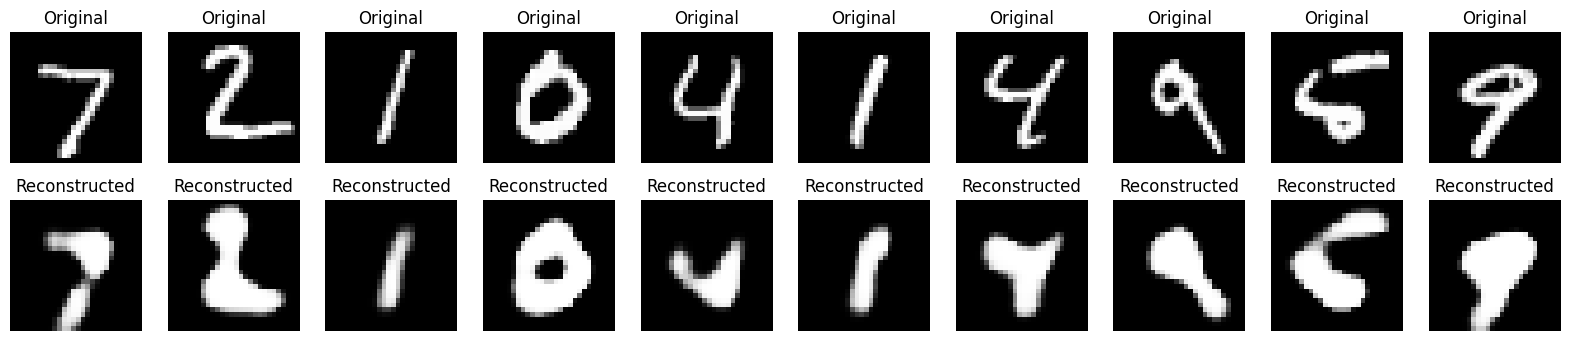

In [11]:
visualize_reconstruction(model1, testloader, num_images=10)

Different model : wider bottleneck - more neurons to encode

In [12]:
model2 = nn.Sequential(   #28x28
    nn.ZeroPad2d(2),  #32x32
    conv(1,2),        #16x16
    conv(2,4),        #8x8
    # conv(4,8),        #4x4
    # deconv(8,4),      #8x8
    deconv(4,2),      #16x16
    deconv(2,1, act=False), #32x32
    nn.ZeroPad2d(-2), #28x28
    nn.Sigmoid()
).to(device)

In [13]:
optimizer = torch.optim.SGD(model2.parameters(), lr=0.1)
fit(4, model2, distance, optimizer, dataloader, testloader)

0 0.502
1 0.494
2 0.493
3 0.491


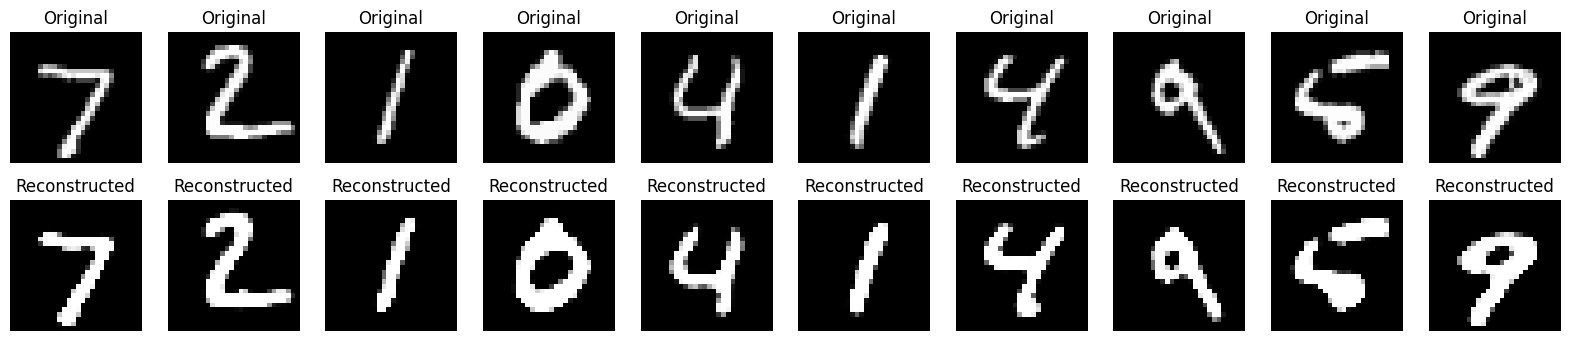

In [14]:
visualize_reconstruction(model2, testloader, num_images=10)

## Glassner book models

In [52]:
class Autoencoder(nn.Module):

    def __init__(self):
        super(Autoencoder,self).__init__()
        
        self.encoder = nn.Sequential(           #28
            nn.Conv2d(1, 16, kernel_size=3, padding=1),   #28
            nn.ReLU(True),
            nn.MaxPool2d(2,2),                 #14
            nn.Conv2d(16, 8, kernel_size=3, padding=1),    #14
            nn.ReLU(True),
            nn.MaxPool2d(2,2),                  #7
            nn.Conv2d(8, 3, kernel_size=3, padding=1),     #7
            nn.ReLU(True)
        )

        self.decoder = nn.Sequential(             
            nn.UpsamplingNearest2d(scale_factor=2),  #14
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.UpsamplingNearest2d(scale_factor=2),   #28
            nn.Conv2d(16, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
            )


    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [53]:
# Model and other definitions
model3 = Autoencoder().to(device)  # Move model to GPU
distance = nn.MSELoss()
optimizerAdam = torch.optim.Adam(model3.parameters(), weight_decay=1e-5)

In [24]:
data = next(iter(dataloader))

In [31]:
test_batch = data[0].to(device)

In [54]:
fit(4, model3, distance, optimizerAdam, dataloader, testloader)

0 0.493
1 0.488
2 0.486
3 0.485


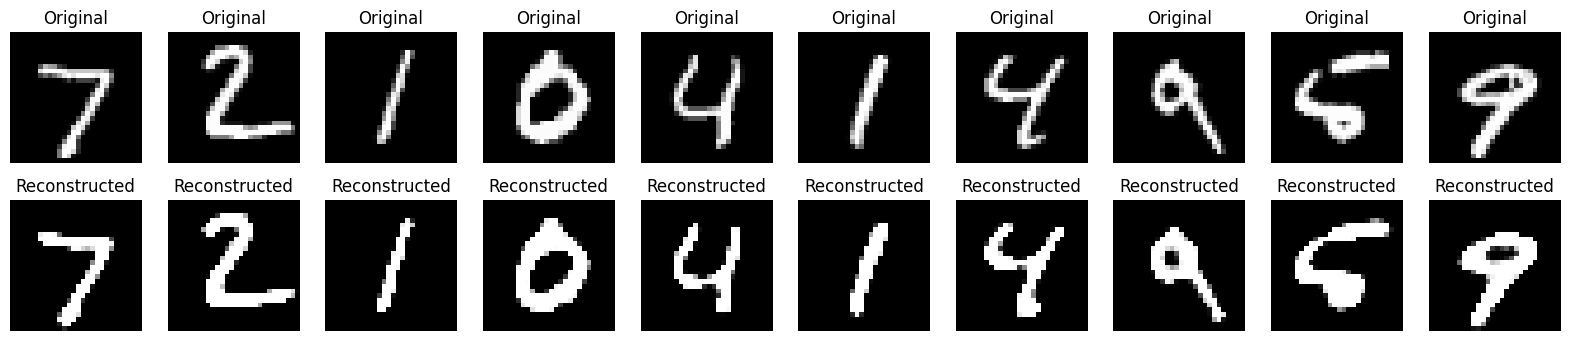

In [55]:
visualize_reconstruction(model3, testloader, num_images=10)

Let's make a Denoising model

In [86]:
# Custom transform to add noise
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        noise = torch.randn(tensor.size()) * self.std + self.mean
        return tensor + noise

    def __repr__(self):
        return self.__class__.__name__ + f'(mean={self.mean}, std={self.std})'

# Transform with added noise
transform_with_noise = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    AddGaussianNoise(0., 1)
])

In [87]:
# Create noised datasets
trainset_noised = tv.datasets.MNIST(root='./data', train=True, download=True, transform=transform_with_noise)
testset_noised = tv.datasets.MNIST(root='./data', train=False, download=True, transform=transform_with_noise)

# Create noised dataloaders
dataloader_noised = torch.utils.data.DataLoader(trainset_noised, batch_size=32, shuffle=False, num_workers=4)
testloader_noised = torch.utils.data.DataLoader(testset_noised, batch_size=32, shuffle=False, num_workers=2)

In [77]:
def add_noise_to_batch(batch, mean=0., std=0.1):
    noise = torch.randn_like(batch) * std + mean
    return batch + noise

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


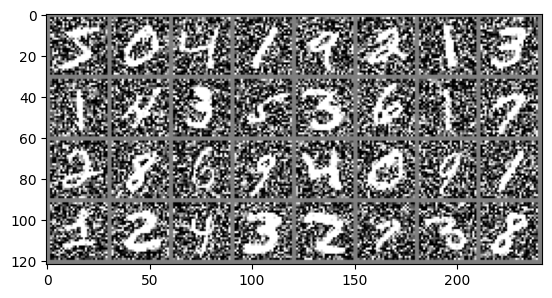

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


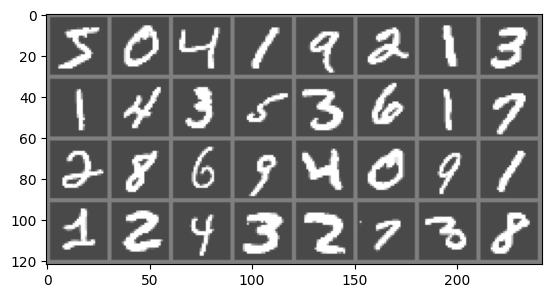

In [91]:
images, labels = next(iter(dataloader_noised))

def imshow(img):
    img = img / 2 + 0.5  # Unnormalize the image
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

imshow(tv.utils.make_grid(images))

images, labels = next(iter(dataloader))
imshow(tv.utils.make_grid(images))

In [73]:
class AutoencoderDenoise(nn.Module):

    def __init__(self):
        super(AutoencoderDenoise,self).__init__()
        
        self.encoder = nn.Sequential(           #28
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),   #28
            nn.ReLU(True),
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),    #14
            nn.ReLU(True)
            )

        self.decoder = nn.Sequential(             
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  #14
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  #28
            nn.ReLU(True),   
            nn.Conv2d(32, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
            )


    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [89]:
# Model and other definitions
model4 = AutoencoderDenoise().to(device)  # Move model to GPU
distance = nn.MSELoss()
optimizerAdam = torch.optim.Adam(model4.parameters(), weight_decay=1e-5)

Let's modify **fit** function to incorporate the addition noise to the data 

In [94]:
def eval(model, loss_func, valid_dl_noise, valid_dl, epoch=0):
    model.eval()
    with torch.no_grad():
        tot_loss,count = 0.,0
        for (data, _), (data_noised, _) in zip(valid_dl, valid_dl_noise):
        # for xb,_ in valid_dl:
            pred = model(data.to(device))
            n = len(data.to(device))
            count += n
            tot_loss += loss_func(pred,data_noised.to(device)).item()*n
    print(epoch, f'{tot_loss/count:.3f}')
    
    
def fit(epochs, model, loss_func, opt,train_dl_noise, train_dl,valid_dl_noise, valid_dl):
    for epoch in range(epochs):
        model.train()
        for (data, _), (data_noised, _) in zip(dataloader, dataloader_noised):
            loss = loss_func(model(data_noised.to(device)), data.to(device))
        # for xb,_ in train_dl:
        #     xb = xb.to(device)
        #     loss = loss_func(model(xb_noised), xb)

            loss.backward()
            opt.step()
            opt.zero_grad()

        eval(model, loss_func,valid_dl_noise, valid_dl, epoch)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


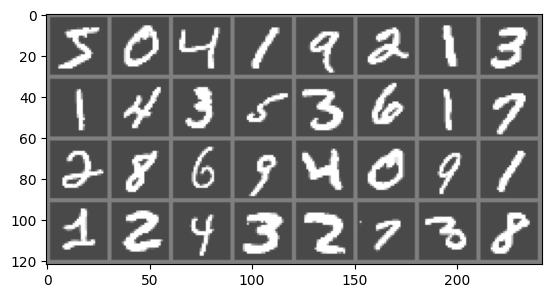

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


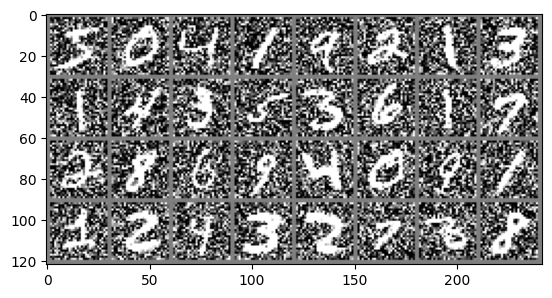

In [93]:
for (data, _), (data_noised, _) in zip(dataloader, dataloader_noised):
    imshow(tv.utils.make_grid(data))
    imshow(tv.utils.make_grid(data_noised))
    break

In [96]:
fit(4, model4, distance, optimizerAdam, dataloader_noised, dataloader,testloader_noised, testloader)

0 1.479
1 1.477
2 1.475
3 1.475


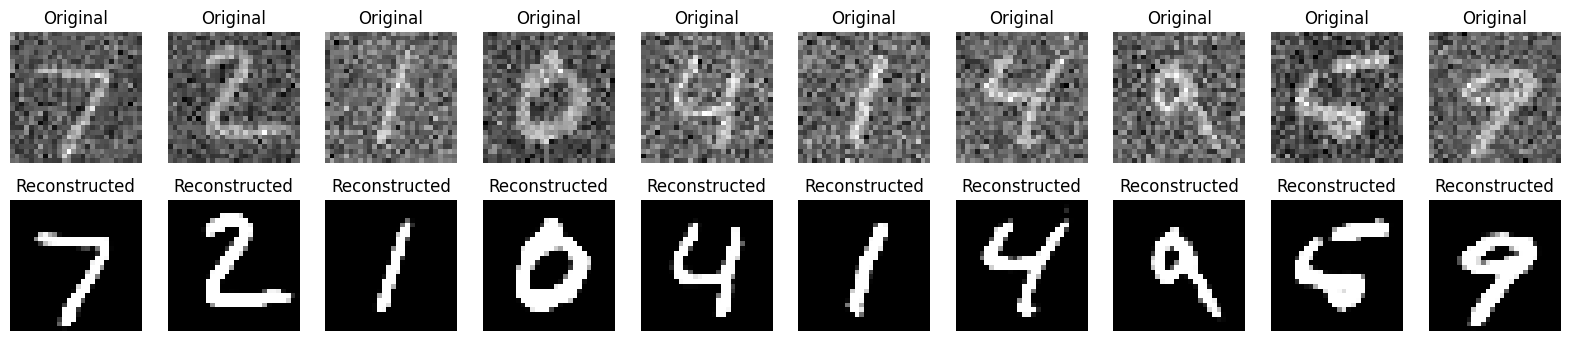

In [98]:
visualize_reconstruction(model4, testloader_noised, num_images=10)